**1. Set Up the Environment**

In [12]:
!pip install pandas numpy tensorflow keras scikit-learn matplotlib seaborn


**2. Load and Preprocess Data**

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the dataset with whitespace delimiter and update based on the future warning
data = pd.read_csv('/content/train_FD001.txt', sep='\s+', header=None)

# Assign column names (adding a placeholder for the extra column)
data.columns = ['unit', 'time'] + [f'sensor_{i}' for i in range(1, 24)] + ['extra']

# Drop the extra column if it contains no useful data
data = data.drop(columns=['extra'])

# Normalize data
scaler = MinMaxScaler()
data[data.columns[2:]] = scaler.fit_transform(data[data.columns[2:]])

# Split data into features and labels
X = data.drop(columns=['unit', 'time'])
y = data['sensor_1']  # Example: assuming sensor_1 degradation as a target for simplicity


**3. Build a Generative Model for Synthetic Data Generation (GAN)**

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

# Define the Generator
def build_generator(input_dim, output_dim):
    model = Sequential([
        Dense(128, input_dim=input_dim),
        LeakyReLU(0.2),
        BatchNormalization(momentum=0.8),
        Dense(256),
        LeakyReLU(0.2),
        BatchNormalization(momentum=0.8),
        Dense(512),
        LeakyReLU(0.2),
        BatchNormalization(momentum=0.8),
        Dense(output_dim, activation='linear')
    ])
    return model

# Define the Discriminator
def build_discriminator(input_dim):
    model = Sequential([
        Dense(512, input_dim=input_dim),
        LeakyReLU(0.2),
        Dropout(0.3),
        Dense(256),
        LeakyReLU(0.2),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

# Set dimensions for GAN
input_dim = X.shape[1]
output_dim = X.shape[1]
generator = build_generator(input_dim=input_dim, output_dim=output_dim)
discriminator = build_discriminator(input_dim=output_dim)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**4. Compile the GAN Model**

In [16]:
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
discriminator.trainable = False

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

z = Input(shape=(input_dim,))
fake_data = generator(z)
valid = discriminator(fake_data)
gan = Model(z, valid)
gan.compile(loss='binary_crossentropy', optimizer='adam')


**5. Train the GAN Model to Generate Synthetic Data**

In [17]:
import numpy as np

def train_gan(epochs, batch_size=64):
    real_data = X.values
    for epoch in range(epochs):
        # Train Discriminator with real and synthetic data
        idx = np.random.randint(0, real_data.shape[0], batch_size)
        real_samples = real_data[idx]

        noise = np.random.normal(0, 1, (batch_size, input_dim))
        synthetic_samples = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_samples, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(synthetic_samples, np.zeros((batch_size, 1)))

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, input_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {0.5 * np.add(d_loss_real, d_loss_fake)[0]}] [G loss: {g_loss}]")

# Train GAN
train_gan(epochs=50, batch_size=64)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.7154464721679688] [G loss: [array(0.7110163, dtype=float32), array(0.7110163, dtype=float32), array(0.2890625, dtype=float32)]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━

**6. Generate Synthetic Data for Predictive Maintenance**

In [18]:
synthetic_data = generator.predict(np.random.normal(0, 1, (1000, input_dim)))
synthetic_df = pd.DataFrame(synthetic_data, columns=X.columns)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


**7. Build a Predictive Maintenance Model**

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Create the predictive maintenance model
predictive_model = Sequential([
    Dense(64, activation='relu', input_dim=input_dim),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
predictive_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train on synthetic data
y_synthetic = np.random.randint(0, 2, synthetic_df.shape[0])  # Random labels for demo purposes
predictive_model.fit(synthetic_df, y_synthetic, epochs=50, batch_size=32)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4816 - loss: 1.3385
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5330 - loss: 0.7217  
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4975 - loss: 0.7083 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5431 - loss: 0.6925 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5659 - loss: 0.6756 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5849 - loss: 0.6749 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6063 - loss: 0.6565 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5838 - loss: 0.6813 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6105 - loss: 0.6560
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6402 - loss: 0.6574 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6000 - loss: 0.6608 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 

**8. Evaluate and Test the Predictive Model**

645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


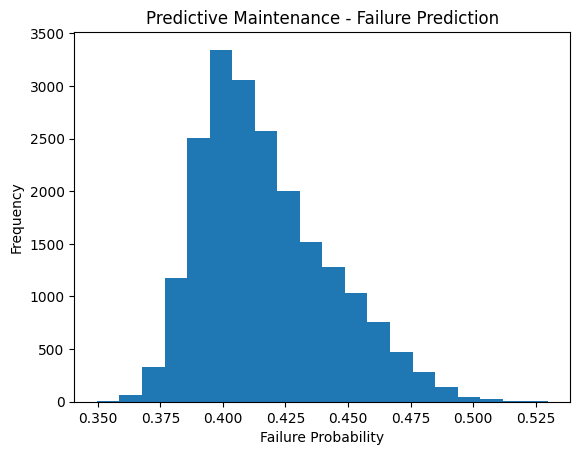

In [20]:
# Predict on test data (real data in this case)
predictions = predictive_model.predict(X)

# Visualize results
plt.hist(predictions, bins=20)
plt.xlabel("Failure Probability")
plt.ylabel("Frequency")
plt.title("Predictive Maintenance - Failure Prediction")
plt.show()
